In [2]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding_script import angle_encoding
from haar_noising import apply_haar_scrambling

filename = "../../data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 1000

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
                qml.RZ(layer[i], wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0]) 

        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out
    
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.dropout2 = nn.Dropout(0.1)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return x
    
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_qubits = 16
n_layers = 1

model = DiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (quantum_layer): QuantumLayer()
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


Epoch [1/10], Loss: 1.0545
Epoch [2/10], Loss: 1.0120
Epoch [3/10], Loss: 0.9705
Epoch [4/10], Loss: 0.9300
Epoch [5/10], Loss: 0.8904
Epoch [6/10], Loss: 0.8519
Epoch [7/10], Loss: 0.8144
Epoch [8/10], Loss: 0.7778
Epoch [9/10], Loss: 0.7423
Epoch [10/10], Loss: 0.7079


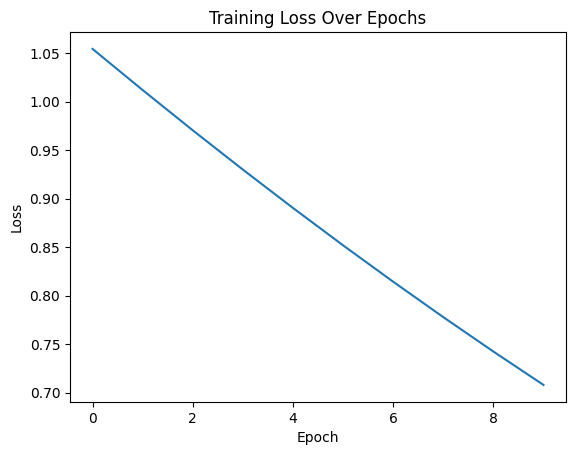

In [4]:
num_epochs = 10
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

[[[[-0.16927044  0.3949955   0.43796855  0.181552  ]
   [ 0.19554059  0.23929268  0.37731516 -0.1543729 ]
   [ 0.04418309  0.226256    0.18084972  0.17598306]
   ...
   [ 0.625528    0.5310355  -0.03636074  0.10997434]
   [ 0.6073779   0.28742492  0.21875949 -0.02607097]
   [ 0.04674752  0.11799005  0.13391191  0.17622931]]

  [[ 0.3626342   0.5419511   0.3231466   0.25963593]
   [ 0.53516483  0.4272979   0.01132976  0.49672574]
   [ 0.33949858  0.32829392  0.3667299   0.30050045]
   ...
   [ 0.29189414  0.06369945  0.13676114  0.35265088]
   [ 0.39170367  0.08332939  0.1682648   0.09424983]
   [ 0.4676841   0.2656186   0.33857974  0.0727266 ]]

  [[-0.03814809  0.2799286   0.2565771  -0.1138816 ]
   [ 0.41786915  0.25383535 -0.09557919  0.55861896]
   [ 0.2874155   0.03561328 -0.27470338  0.11788648]
   ...
   [ 0.25917825 -0.12928891  0.10389479  0.16977489]
   [ 0.04080629  0.03906007  0.2408452   0.2026805 ]
   [ 0.2276429   0.40335613  0.32720414  0.15525672]]

  ...

  [[ 0.15859

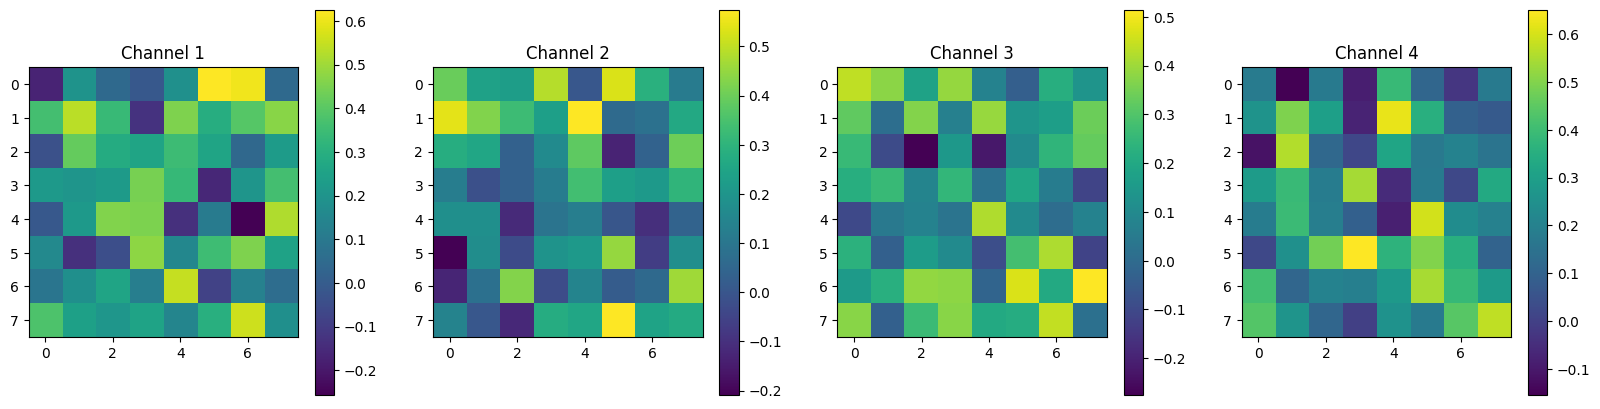

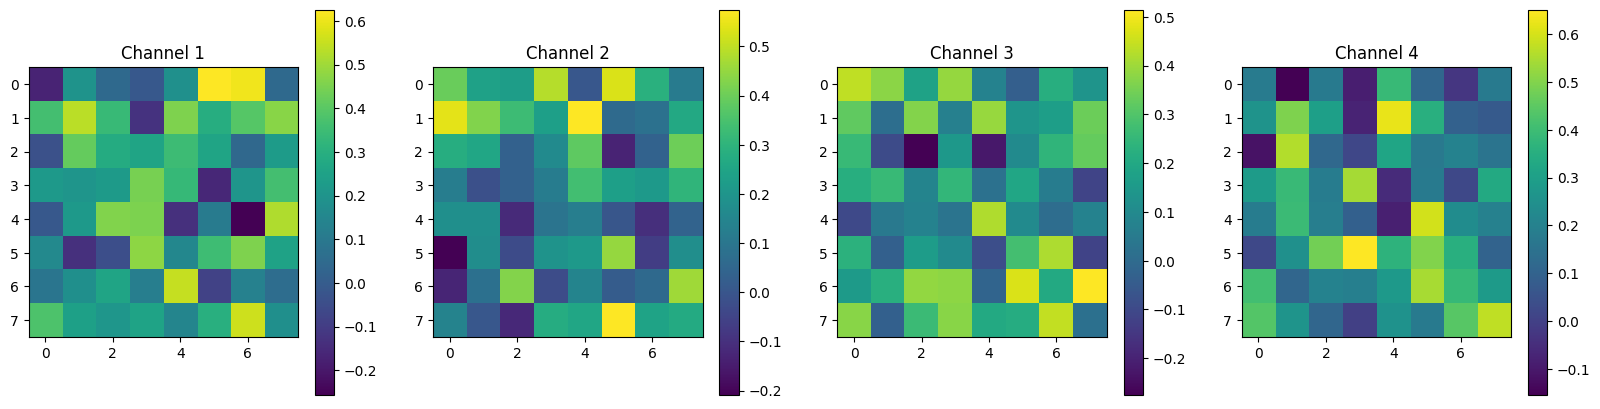

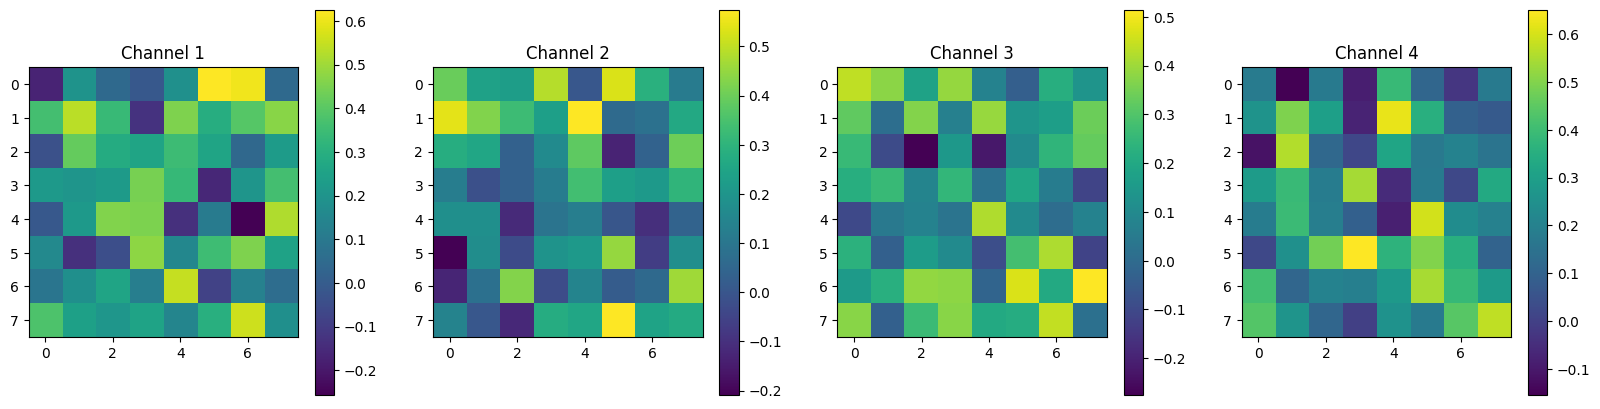

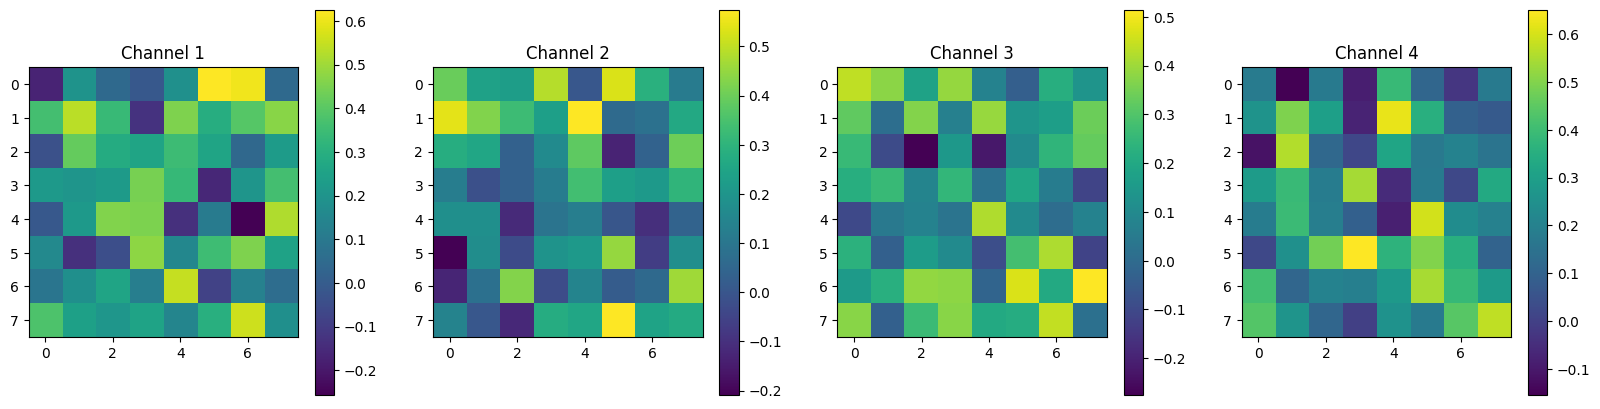

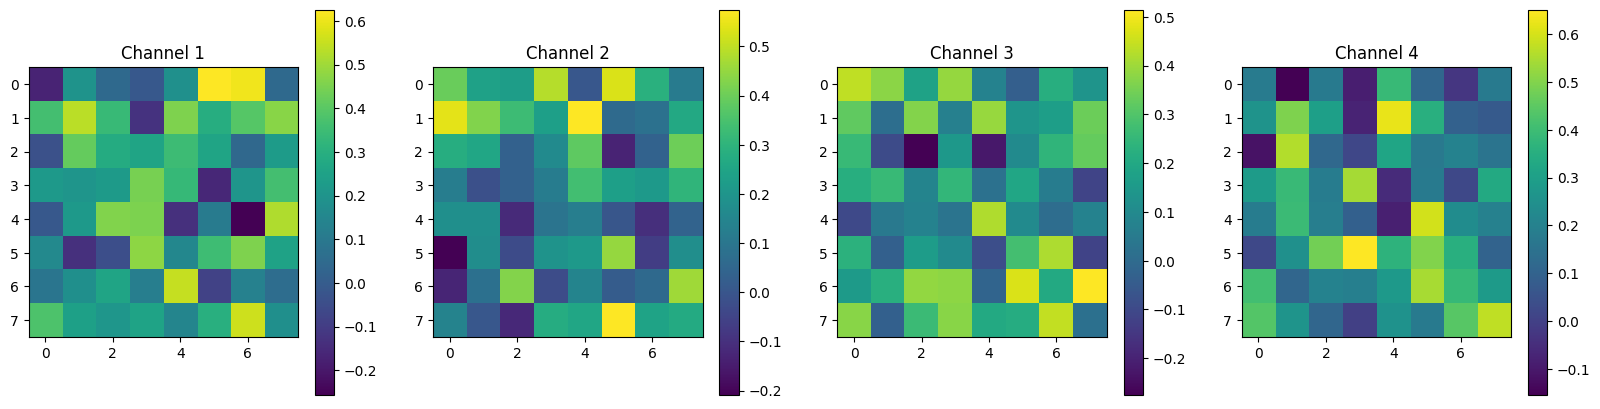

In [6]:
def generate_new_samples(model, num_samples, input_dim):
    random_input = torch.randn(num_samples, input_dim)
    
    model.eval()
    
    with torch.no_grad():
        generated_output = model(random_input)
    
    generated_images = generated_output.view(num_samples, 8, 8, 4).cpu().numpy()
    
    return generated_images

num_samples_to_generate = 5

generated_images = generate_new_samples(model, num_samples_to_generate, input_dim)
print(generated_images)

def visualize_generated_images(images):
    for i in range(images.shape[0]):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Create a figure with 4 subplots side by side
        for channel in range(4):
            ax = axes[channel]
            im = ax.imshow(images[i, :, :, channel], cmap='viridis')
            fig.colorbar(im, ax=ax)  # Add colorbar to each subplot
            ax.set_title(f'Channel {channel+1}')
        plt.show()

visualize_generated_images(generated_images)
